In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


# Data loading and inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load train and test datasets
df = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")
X_test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
df.head

<bound method NDFrame.head of           id  Gender        Age    Height      Weight  \
0          0    Male  24.443011  1.699998   81.669950   
1          1  Female  18.000000  1.560000   57.000000   
2          2  Female  18.000000  1.711460   50.165754   
3          3  Female  20.952737  1.710730  131.274851   
4          4    Male  31.641081  1.914186   93.798055   
...      ...     ...        ...       ...         ...   
20753  20753    Male  25.137087  1.766626  114.187096   
20754  20754    Male  18.000000  1.710000   50.000000   
20755  20755    Male  20.101026  1.819557  105.580491   
20756  20756    Male  33.852953  1.700000   83.520113   
20757  20757    Male  26.680376  1.816547  118.134898   

      family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
0                                yes  yes  2.000000  2.983297   Sometimes   
1                                yes  yes  2.000000  3.000000  Frequently   
2                                yes  yes  1.880534  1

In [3]:
df.info

<bound method DataFrame.info of           id  Gender        Age    Height      Weight  \
0          0    Male  24.443011  1.699998   81.669950   
1          1  Female  18.000000  1.560000   57.000000   
2          2  Female  18.000000  1.711460   50.165754   
3          3  Female  20.952737  1.710730  131.274851   
4          4    Male  31.641081  1.914186   93.798055   
...      ...     ...        ...       ...         ...   
20753  20753    Male  25.137087  1.766626  114.187096   
20754  20754    Male  18.000000  1.710000   50.000000   
20755  20755    Male  20.101026  1.819557  105.580491   
20756  20756    Male  33.852953  1.700000   83.520113   
20757  20757    Male  26.680376  1.816547  118.134898   

      family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
0                                yes  yes  2.000000  2.983297   Sometimes   
1                                yes  yes  2.000000  3.000000  Frequently   
2                                yes  yes  1.880534 

In [4]:
X_test.info

<bound method DataFrame.info of           id  Gender        Age    Height      Weight  \
0      20758    Male  26.899886  1.848294  120.644178   
1      20759  Female  21.000000  1.600000   66.000000   
2      20760  Female  26.000000  1.643355  111.600553   
3      20761    Male  20.979254  1.553127  103.669116   
4      20762  Female  26.000000  1.627396  104.835346   
...      ...     ...        ...       ...         ...   
13835  34593    Male  23.327836  1.721384   78.030383   
13836  34594  Female  29.000000  1.590000   62.000000   
13837  34595  Female  22.935612  1.585547   44.376637   
13838  34596    Male  21.000000  1.620000   53.000000   
13839  34597    Male  26.490926  1.812259  120.980508   

      family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
0                                yes  yes  2.938616  3.000000   Sometimes   
1                                yes  yes  2.000000  1.000000   Sometimes   
2                                yes  yes  3.000000 

# Checking and handling duplicates and missing values

In [5]:
# check duplicates
df.duplicated().sum()

0

In [6]:
# check missing values
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

# Analyzing unique values to identify categorical and continuous variables

In [7]:
# check the number of unique values or categories of each column
for col_name in df.columns:
    unique_cat, name = len(df[col_name].unique()), df[col_name].unique()
    print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'id' has 20758 unique categories
Feature 'Gender' has 2 unique categories
Feature 'Age' has 1703 unique categories
Feature 'Height' has 1833 unique categories
Feature 'Weight' has 1979 unique categories
Feature 'family_history_with_overweight' has 2 unique categories
Feature 'FAVC' has 2 unique categories
Feature 'FCVC' has 934 unique categories
Feature 'NCP' has 689 unique categories
Feature 'CAEC' has 4 unique categories
Feature 'SMOKE' has 2 unique categories
Feature 'CH2O' has 1506 unique categories
Feature 'SCC' has 2 unique categories
Feature 'FAF' has 1360 unique categories
Feature 'TUE' has 1297 unique categories
Feature 'CALC' has 3 unique categories
Feature 'MTRANS' has 5 unique categories
Feature 'NObeyesdad' has 7 unique categories


# Frequency analysis for categorical variables

In [8]:
# Check frequency and relative frequency for categorical features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

for feature in categorical_features:
    # Display frequency and relative frequency
    print("\nFeature: ", feature)
    print(df[feature].value_counts())
    print(df[feature].value_counts(normalize=True))
    print("--------------------------")



Feature:  Gender
Gender
Female    10422
Male      10336
Name: count, dtype: int64
Gender
Female    0.502071
Male      0.497929
Name: proportion, dtype: float64
--------------------------

Feature:  family_history_with_overweight
family_history_with_overweight
yes    17014
no      3744
Name: count, dtype: int64
family_history_with_overweight
yes    0.819636
no     0.180364
Name: proportion, dtype: float64
--------------------------

Feature:  FAVC
FAVC
yes    18982
no      1776
Name: count, dtype: int64
FAVC
yes    0.914443
no     0.085557
Name: proportion, dtype: float64
--------------------------

Feature:  CAEC
CAEC
Sometimes     17529
Frequently     2472
Always          478
no              279
Name: count, dtype: int64
CAEC
Sometimes     0.844446
Frequently    0.119087
Always        0.023027
no            0.013441
Name: proportion, dtype: float64
--------------------------

Feature:  SMOKE
SMOKE
no     20513
yes      245
Name: count, dtype: int64
SMOKE
no     0.988197
yes    0.0118

In [9]:
# Display the data types of each column
numerical_features = df.dtypes[df.dtypes != 'object'].index
numerical_data_types = df[numerical_features].dtypes
print(numerical_data_types)



id          int64
Age       float64
Height    float64
Weight    float64
FCVC      float64
NCP       float64
CH2O      float64
FAF       float64
TUE       float64
dtype: object


# Statistical summary for numerical features

In [10]:
# Display the statistical summary of numerical features
numerical_summary = df[numerical_features].describe()
print(numerical_summary)


                id           Age        Height        Weight          FCVC  \
count  20758.00000  20758.000000  20758.000000  20758.000000  20758.000000   
mean   10378.50000     23.841804      1.700245     87.887768      2.445908   
std     5992.46278      5.688072      0.087312     26.379443      0.533218   
min        0.00000     14.000000      1.450000     39.000000      1.000000   
25%     5189.25000     20.000000      1.631856     66.000000      2.000000   
50%    10378.50000     22.815416      1.700000     84.064875      2.393837   
75%    15567.75000     26.000000      1.762887    111.600553      3.000000   
max    20757.00000     61.000000      1.975663    165.057269      3.000000   

                NCP          CH2O           FAF           TUE  
count  20758.000000  20758.000000  20758.000000  20758.000000  
mean       2.761332      2.029418      0.981747      0.616756  
std        0.705375      0.608467      0.838302      0.602113  
min        1.000000      1.000000      0.

# Correlation analysis among numerical features and between features and the target variable

In [11]:
# Calculate correlation matrix
correlation_matrix = df[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']].corr()

# Display the correlation matrix
correlation_matrix


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154
Height,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433
Weight,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471
FCVC,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843
NCP,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459
CH2O,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654
FAF,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213
TUE,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000


# Encoding the target variable for modeling

In [12]:
# Encode the target variable 'NObeyesdad'
df['NObeyesdad_encoded'] = df['NObeyesdad'].astype('category').cat.codes

# Calculate correlations
correlations = df[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'NObeyesdad_encoded']].corr()['NObeyesdad_encoded']

# Display correlations
print(correlations)


Age                   0.283018
Height                0.060786
Weight                0.431821
FCVC                  0.041076
NCP                  -0.091154
CH2O                  0.187100
FAF                  -0.096643
TUE                  -0.076040
NObeyesdad_encoded    1.000000
Name: NObeyesdad_encoded, dtype: float64


# scatter plots

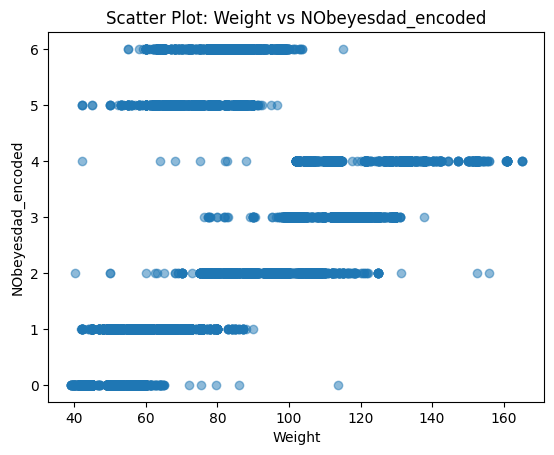

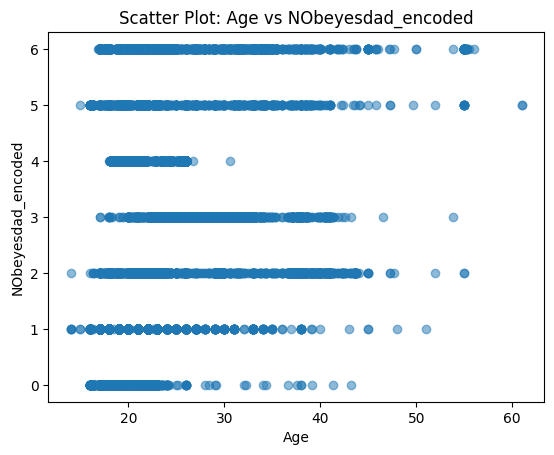

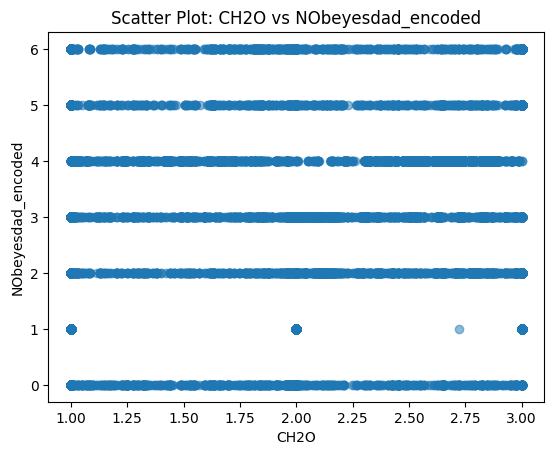

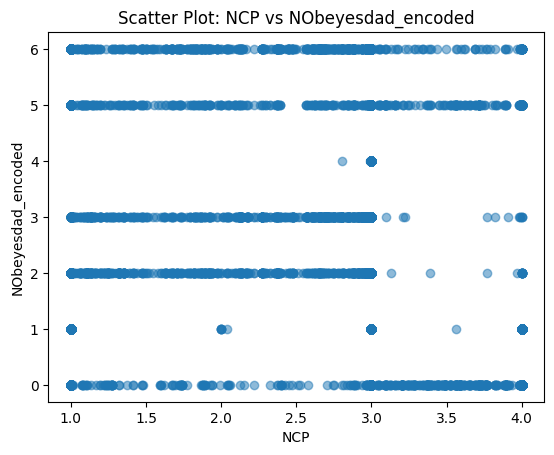

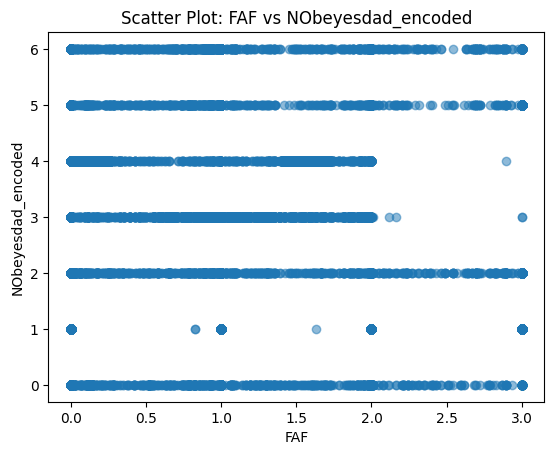

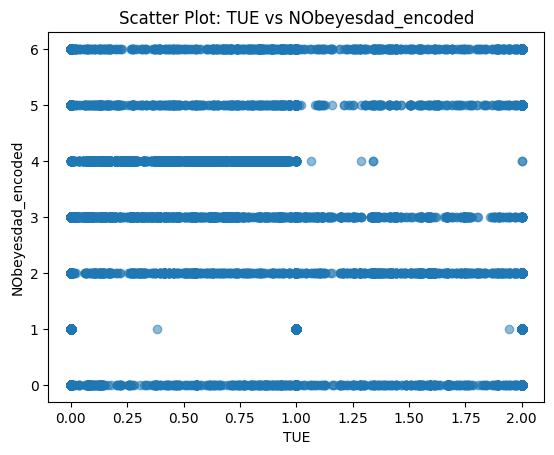

In [13]:
import matplotlib.pyplot as plt

# Select features for visualization
features_to_visualize = ['Weight', 'Age', 'CH2O', 'NCP', 'FAF', 'TUE']

# Plot scatter plots
for feature in features_to_visualize:
    plt.scatter(df[feature], df['NObeyesdad_encoded'], alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs NObeyesdad_encoded')
    plt.xlabel(feature)
    plt.ylabel('NObeyesdad_encoded')
    plt.show()


In [14]:
# Separate features and target variable
X = df.drop(['id', 'NObeyesdad'], axis=1)
y = df['NObeyesdad']

In [15]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# List of numerical and categorical columns (replace with your actual column names)
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

In [17]:
# Preprocessing for numerical data: standard scaling
numerical_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [18]:
# Define the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Train the pipeline (fit the model)
pipeline.fit(X_train, y_train)

# Predict on validation set
val_predictions = pipeline.predict(X_val)

In [19]:
# Evaluate the model
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation accuracy: {val_accuracy}')

Validation accuracy: 0.8860789980732178


In [20]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [21]:
X_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

#drop 'id' from the test set
X_test = X_test.drop(['id'], axis=1)

test_predictions = pipeline.predict(X_test)

In [22]:
# Prepare the submission file
submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
submission['NObeyesdad'] = test_predictions

# Save the submission file (replace '/path/to/submission.csv' with your actual file path)
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [23]:
# Perform cross-validation and then retrain on the full training set
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f'CV accuracy scores: {cv_scores}')
print(f'Mean CV accuracy: {np.mean(cv_scores)}')

CV accuracy scores: [0.88681517 0.89370671 0.88075881 0.89009335 0.90665462]
Mean CV accuracy: 0.891605732299212


In [24]:
# Hyperparameter tuning using Grid Search with a defined parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

In [25]:
search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'CAEC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CALC',
                                                                          'MTRANS'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [26]:
print(f'Best parameters: {search.best_params_}')
print(f'Best CV accuracy: {search.best_score_}')

Best parameters: {'model__max_depth': 30, 'model__min_samples_split': 5, 'model__n_estimators': 300}
Best CV accuracy: 0.8936532720735597
